Loading the dataset

In [ ]:
import pandas as pd  

In [ ]:
data = pd.read_csv('use_this.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,tweet,sentiment,label
0,0,0,agree ayushmann khurrana best documentary revo...,1,1
1,1,1,pm modi imran khan asks kashmir given pakistan...,0,0
2,2,2,idea democracy peril today least kashmiri invo...,-1,2
3,3,3,unity good uniformity rakhahari chatterji arti...,1,1
4,4,4,sub acha fabricated take youtube article,0,0


In [ ]:
X = data
Y = data.label

Transforming the labels from 0, 1, 2 to vectors of shape [3]

*   [1,0,0] : neutral
*   [0,1,0] : positive
*   [0,0,1] : negative




In [ ]:
from keras.utils import to_categorical
Y = to_categorical(Y)
Y

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))
y_train

TRAIN size: 11090
TEST size: 11091


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

Preparing the word embeddings

In [ ]:
import gensim

W2V_SIZE = 300
W2V_WINDOW = 5
W2V_EPOCH = 25
W2V_MIN_COUNT = 5

documents = [_text.split() for _text in X_train.tweet] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)

words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 4081


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(3246232, 4300600)

Tokenizing sequences

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.tweet)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 16772 unique tokens.


Padding the sequences to length 300

In [ ]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300
X_train_padded = tokenizer.texts_to_sequences(X_train.tweet)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = tokenizer.texts_to_sequences(X_test.tweet)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (11090, 300)


LSTM model

In [ ]:
from keras.layers import LSTM,Bidirectional
max_features = 180000
inputs = Input(shape=(300,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = LSTM(64)(x)
#x = Bidirectional(LSTM(128, return_sequences=True))(x)
#x = Bidirectional(LSTM(64))(x)
# Add a classifier
x=Dense(100)(x)
x=Dropout(0.5)(x)
#x = Flatten()(x)
#x = Dense(128)(x)
#x = Dropout(0.5)(x)
x=LeakyReLU(alpha = 0.2)(x)
outputs = Dense(3,activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 300, 128)          23040000  
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303 

In [ ]:
history = model.fit(X_train_padded, y_train, epochs = 2, batch_size=64)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
11090/11090 [==============================] - 97s 9ms/step - loss: 0.6238 - acc: 0.7395
Epoch 2/2
11090/11090 [==============================] - 98s 9ms/step - loss: 0.1619 - acc: 0.9453


CNN Model

In [ ]:
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, Activation,LeakyReLU
from keras.layers import Embedding,BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D,LSTM
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input,Flatten,concatenate
from keras import metrics

In [ ]:
max_features = 18000
maxlen = 300
batch_size = 64
embedding_dims = 100
filters = 64
kernel_size = 1
hidden_dims = 100
epochs = 4

main_input = Input(shape=(300,), dtype='int32', name='main_input')
x=Embedding(max_features
            ,embedding_dims
            ,input_length=maxlen)(main_input)
y=Dropout(0.5)(x)
filtersize=[1,2]
convs=[]
for i in filtersize:
    a=Conv1D(128
             ,kernel_size=i
             ,padding='valid'
             ,activation='tanh'
             ,strides=1)(y)
    b=MaxPooling1D(pool_size=3)(a)
    convs.append(b)

merge=concatenate(convs, axis=1)

conv=Conv1D(128
            ,kernel_size=3
            ,padding='valid'
            ,activation='tanh'
            ,strides=1)(merge)
x=Activation('relu')(conv)
#x=BatchNormalization()(x)
x=GlobalMaxPooling1D()(x)


x=Dense(100)(x)
x=Dropout(0.5)(x)
#x = Flatten()(x)
#x = Dense(128)(x)
#x = Dropout(0.5)(x)
x=LeakyReLU(alpha = 0.2)(x)

pred = Dense(3,activation='softmax')(x)

model=Model(main_input,pred)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

In [ ]:
history = model.fit(X_train_padded, y_train, epochs = 4, batch_size=64)

ValueError: ignored

Getting predictions of any model into preds list
This list will contain predictions as probabilities so we need to take the maximum and flatten it to make the confusion matrix

In [ ]:
preds = model.predict(X_test_padded)
preds

array([[1.3142969e-05, 3.6906920e-06, 9.9998319e-01],
       [1.2402628e-05, 9.9995947e-01, 2.8138144e-05],
       [1.2273316e-05, 9.9990988e-01, 7.7783239e-05],
       ...,
       [1.0394091e-03, 9.9776900e-01, 1.1915889e-03],
       [9.9997818e-01, 1.8688455e-05, 3.1031495e-06],
       [9.9869943e-01, 9.2618674e-04, 3.7432782e-04]], dtype=float32)

Loop to set max probability as 1 and rest as 0

In [ ]:
for i in range(len(preds)):
  mx = 0
  ind = -1
  for j in range(3):
    if preds[i][j] > mx:
      mx = preds[i][j]
      ind = j
  preds[i][ind] = 1.0
  preds[i][(ind+1)%3] = 0.0
  preds[i][(ind+2)%3] = 0.0

preds

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

Mapping the [3,] vector to a 1D list

In [ ]:
y_test_1d = []
for p in y_test:
  for j in range(3):
    if p[j] == 1.0:
      y_test_1d.append(j)

preds_1d = []
for p in preds:
  for j in range(3):
    if p[j] == 1.0:
      preds_1d.append(j)

print(y_test_1d)
print(preds_1d)

[2, 1, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 0, 1, 1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 2, 0, 1, 1, 0, 0, 

Making the confusion matric using seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Normalized confusion matrix
[[0.86492375 0.1276066  0.00746965]
 [0.0056839  0.98478181 0.00953429]
 [0.0400165  0.1109736  0.8490099 ]]


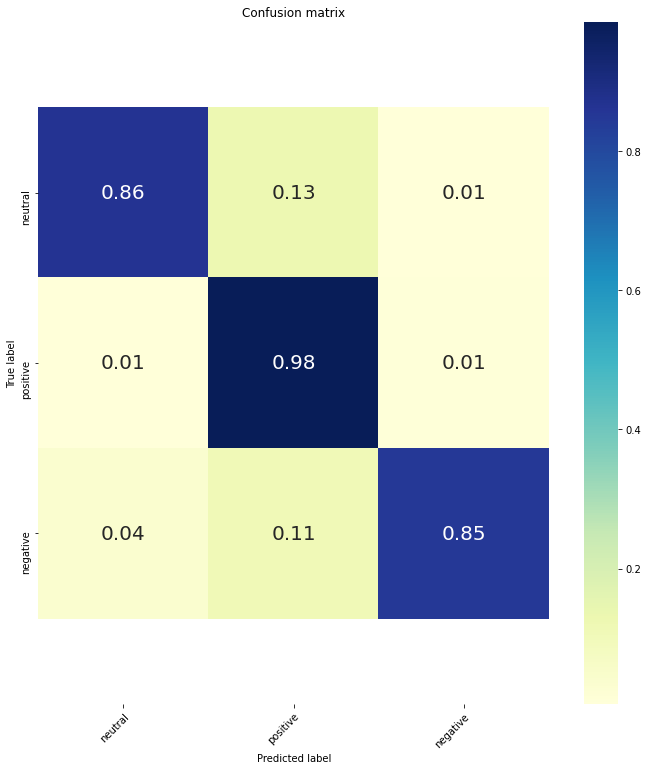

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics

class_names = ['neutral','positive','negative']
cnf_matrix = metrics.confusion_matrix(y_test_1d, preds_1d)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
print(cnf_matrix)
fig, ax = plt.subplots(figsize=(10,10))
tick_marks = np.arange(len(class_names))
sb.heatmap(pd.DataFrame(cnf_matrix,class_names,class_names), annot=True,annot_kws={"size": 20},square = True, cmap="YlGnBu" ,fmt='.2f')
ax.xaxis.set_label_position("bottom")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

For plotting training accuracies and losses

dict_keys(['loss', 'acc'])




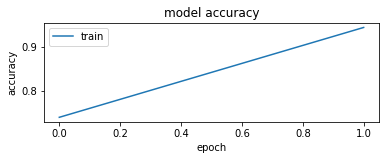

In [ ]:
print(history.history.keys())  
import matplotlib.pyplot as plt 
plt.figure(1)  
  
# summarize history for accuracy  
  
plt.subplot(211)  
plt.plot(history.history['acc'])  
#plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
print("\n")  
# summarize history for loss  
  


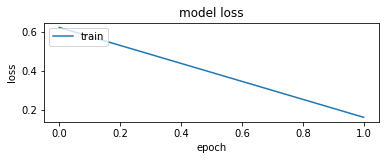

In [ ]:
plt.subplot(212)  
plt.plot(history.history['loss'])  
#plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  